*It's a method used to determine customer value by looking at three dimensions:*

- **Recency**: When is the last time the user takes an action?
- **Frequency**: How many times does the user take this action?
- **Monetary**: What is the sum of monetary value from this user throughout his/her lifetime?

- *Recency : the interval between the **last action** and **today***
- *Frequency : the number of action between the user's **signup date** and **today***
- *Monetary : the sum of revenue within the user's lifetime*

### Library

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px


In [ ]:
df = pd.read_csv("/content/online_retail_listing.csv",delimiter=";",encoding="unicode_escape")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def check_df(df):
    print("---------------- Shape ----------------")
    print(df.shape)
    print("---------------- Columns ----------------")
    print(df.columns)
    print("---------------- Types ----------------")
    print(df.dtypes)
    print("---------------- Head ----------------")
    print(df.head())
    print("---------------- Tail ----------------")
    print(df.tail())
    print("---------------- Describe ----------------")
    print(df.describe().T)

check_df(df)

---------------- Shape ----------------
(36915, 8)
---------------- Columns ----------------
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
---------------- Types ----------------
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price           object
Customer ID    float64
Country         object
dtype: object
---------------- Head ----------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 07

In [ ]:
df["Price"] = df["Price"].str.replace(",",".").astype("float64")

In [ ]:
df.Price.max()

1998.49

In [ ]:
df["Total_Price"] = df["Quantity"] * df["Price"]
df["Total_Price"].head()

0     83.4
1     81.0
2     81.0
3    100.8
4     30.0
Name: Total_Price, dtype: float64

## Missing data analysis

In [ ]:
(df
.isna()
.mean()
.mul(100))

Invoice         0.000000
StockCode       0.000000
Description     0.208587
Quantity        0.000000
InvoiceDate     0.000000
Price           0.002709
Customer ID    26.579981
Country         0.002709
Total_Price     0.002709
dtype: float64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
Total_Price    0
dtype: int64

## Outlier Engineering

<Axes: >

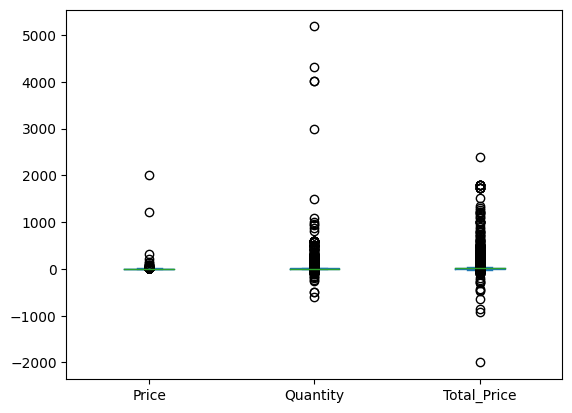

In [ ]:
df[["Price","Quantity","Total_Price"]].plot(kind="box")


In [ ]:
def outlier(data,col):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower = data[col].quantile(0.25) - (IQR * 1.5)
    upper  = data[col].quantile(0.75) + (IQR * 1.5)
    b_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"Total Outliers of the {col} : {b_total}")
    df[col] = np.where(df[col]<lower,lower,np.where(df[col]>upper,upper,data[col]))
    a_total = df[(df[col] > upper) | (df[col] < lower)].shape[0]
    print(f"(After Replacement) Total Outliers of the {col} : {a_total}")

In [ ]:
for col in ["Quantity","Price","Total_Price"]:
    outlier(df,col)

Total Outliers of the Quantity : 1896
(After Replacement) Total Outliers of the Quantity : 0
Total Outliers of the Price : 1438
(After Replacement) Total Outliers of the Price : 0
Total Outliers of the Total_Price : 2579
(After Replacement) Total Outliers of the Total_Price : 0


### How many unique items in the dataset?

In [ ]:
df["Description"].nunique()

2653

### Remove the canceled transactions from the dataset


In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]

### Drop duplicate

In [ ]:
df.drop_duplicates(subset=["Invoice", "Customer ID"], keep="first", inplace=True)


## Calculating of RFM metrics

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"].max() # last purchase '9.12.2010 20:01'
today_date = dt.datetime(2012,1,1)


In [ ]:
rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate" : lambda date: (today_date - date.max()).days,
    "Invoice" : lambda num: num.nunique(),
    "Total_Price": lambda  TotalPrice: TotalPrice.sum()}
)

rfm.columns=["Recency","Frequency","Monetary"]
rfm = rfm[rfm["Monetary"] > 0]

In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,879.0,869.516496,118.389283,745.00,747.00,840.00,993.00,1083.00
Frequency,879.0,1.444824,1.119853,1.00,1.00,1.00,2.00,15.00
Monetary,879.0,31.506519,40.811575,0.21,11.25,20.16,43.65,480.15


In [ ]:
rfm["R_Score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,747,3,88.65,5,5,5,555
12358.0,871,1,17.70,3,1,3,313
12359.0,745,2,37.24,5,4,4,544
12362.0,1083,1,43.65,1,1,4,114
12417.0,810,2,21.10,4,4,3,443


In [ ]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm["Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,747,3,88.65,5,5,5,555,champions
12358.0,871,1,17.70,3,1,3,313,about_to_sleep
12359.0,745,2,37.24,5,4,4,544,champions
12362.0,1083,1,43.65,1,1,4,114,hibernating
12417.0,810,2,21.10,4,4,3,443,loyal_customers


### Who are the top 10 of our best customers?

In [ ]:
rfm[rfm["RFM_Score"]=='555'].sort_values("Monetary", ascending=False).head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
Customer ID,,,,,,,,
13694.0,745,11,480.15,5,5,5,555,champions
17949.0,746,10,436.50,5,5,5,555,champions
15311.0,745,11,382.01,5,5,5,555,champions
15061.0,745,9,366.60,5,5,5,555,champions
18102.0,746,7,289.34,5,5,5,555,champions
16779.0,745,5,214.20,5,5,5,555,champions
17157.0,747,4,145.95,5,5,5,555,champions
14911.0,746,6,139.95,5,5,5,555,champions
13089.0,747,4,136.05,5,5,5,555,champions


### Summary Statistics for RFM

In [ ]:
(rfm[["Segment","Recency","Frequency", "Monetary"]]
.groupby("Segment")
.agg(["mean","median","count","std","min","max","skew"])
)


Recency                                      \
                            mean  median count        std  min   max   
Segment                                                                
about_to_sleep        856.288136   871.0    59  15.612827  840   871   
at_Risk              1003.359477  1024.0   153  61.903747  902  1083   
cant_loose            996.541667  1024.0    24  62.520243  902  1083   
champions             745.888060   746.0   134   0.762470  745   747   
hibernating           998.958824  1024.0   170  59.959292  902  1083   
loyal_customers       806.336066   810.0   122  44.107422  748   871   
need_attention        854.880000   840.0    25  15.806960  840   871   
new_customers         745.971429   746.0    35   0.857003  745   747   
potential_loyalists   766.917293   748.0   133  27.749159  745   810   
promising             780.291667   779.0    24  26.618854  748   810   

                              Frequency               ...                    \
                         skew      mean median count  ... min max      skew   
Segment                                               ...                     
about_to_sleep      -0.104502  1.000000    1.0    59  ...   1   1  0.000000   
at_Risk             -0.394406  1.052288    1.0   153  ...   1   2  4.062395   
cant_loose          -0.616361  2.833333    2.0    24  ...   2  15  4.280367   
champions            0.192061  2.574627    2.0   134  ...   1  11  2.806132   
hibernating         -0.273059  1.000000    1.0   170  ...   1   1  0.000000   
loyal_customers      0.131387  2.049180    2.0   122  ...   1   7  1.895629   
need_attention       0.085268  1.000000    1.0    25  ...   1   1  0.000000   
new_customers        0.056559  1.000000    1.0    35  ...   1   1  0.000000   
potential_loyalists  0.762703  1.000000    1.0   133  ...   1   1  0.000000   
promising           -0.084021  1.000000    1.0    24  ...   1   1  0.000000   

                      Monetary                                         \
                          mean  median count        std   min     max   
Segment                                                                 
about_to_sleep       23.519831  20.280    59  12.585849  2.55   43.65   
at_Risk              20.843660  15.300   153  16.642900  0.42   87.30   
cant_loose           61.956250  50.375    24  82.134881  3.60  419.75   
champions            65.055672  43.875   134  76.033823  3.81  480.15   
hibernating          19.509176  17.550   170  12.613623  0.21   43.65   
loyal_customers      43.145328  34.615   122  35.876380  1.25  174.60   
need_attention       17.445600  14.850    25  14.057411  2.10   43.65   
new_customers        19.977714  15.300    35  11.738432  5.04   43.65   
potential_loyalists  19.736917  17.000   133  13.757059  0.42   43.65   
promising            23.850417  22.800    24  15.247090  0.65   43.65   

                               
                         skew  
Segment                        
about_to_sleep       0.385971  
at_Risk              1.308118  
cant_loose           3.872259  
champions            3.375150  
hibernating          0.592757  
loyal_customers      1.614959  
need_attention       0.776625  
new_customers        1.119441  
potential_loyalists  0.594427  
promising            0.018201  

[10 rows x 21 columns]

## Clustring With The K-MEANS

In [ ]:
rfm_kmeans = rfm.loc[:,"Recency":"Monetary"]
rfm_kmeans.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,747,3,88.65
12358.0,871,1,17.70
12359.0,745,2,37.24
12362.0,1083,1,43.65
12417.0,810,2,21.10


In [ ]:
scaler = MinMaxScaler()
ndf = scaler.fit_transform(rfm_kmeans)

### Determining the K-Means Cluster Number - Inertia

In [ ]:
max_cluster = 10

all_experiments = []

for n_cluster in range(1,max_cluster,1):
    kmeans = KMeans(n_clusters=n_cluster + 1, random_state=42)
    kmeans.fit(ndf)
    all_experiments.append(kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
k_means = KMeans(n_clusters=6).fit(ndf)
clusters = k_means.labels_
c_ndf=rfm[["Recency","Frequency","Monetary"]]

c_ndf["cluster_no"] = clusters
c_ndf["cluster_no"] = c_ndf["cluster_no"] + 1
c_ndf.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-42-2c4672a08415>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_ndf["cluster_no"] = clusters
<ipython-input-42-2c4672a08415>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_ndf["cluster_no"] = c_ndf["cluster_no"] + 1


,Recency,Frequency,Monetary,cluster_no
Customer ID,,,,
12346.0,747,3,88.65,6
12358.0,871,1,17.70,5
12359.0,745,2,37.24,1
12362.0,1083,1,43.65,2
12417.0,810,2,21.10,5


In [ ]:
fig = px.scatter_3d(c_ndf, x=c_ndf["Recency"], y=c_ndf["Frequency"], z=c_ndf["Monetary"], color=c_ndf["cluster_no"])
fig.show()